# Classifiers - busy vs relaxed - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
def scale_data(x, standardScaler=True, minMaxScaler=True):
    
    if standardScaler:
        # Scale with standard scaler
        sscaler = StandardScaler()
        sscaler.fit(x)
        x = sscaler.transform(x)

    if minMaxScaler:
        # Scale with MinMax to range [0,1]
        mmscaler = MinMaxScaler((0,1))
        mmscaler.fit(x)
        x = mmscaler.transform(x)
    
    return x

In [9]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [10]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [11]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [12]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
phase_all_train = scale_data(phase_all_train)

# load all phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
phase_all_valid = scale_data(phase_all_valid)

In [13]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [14]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [15]:
# AE Training params
batch_size = 256
epochs = 500
encoding_dim = 60
ae_encoded_shape = np.empty((0,encoding_dim))

In [16]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [17]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [18]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [19]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

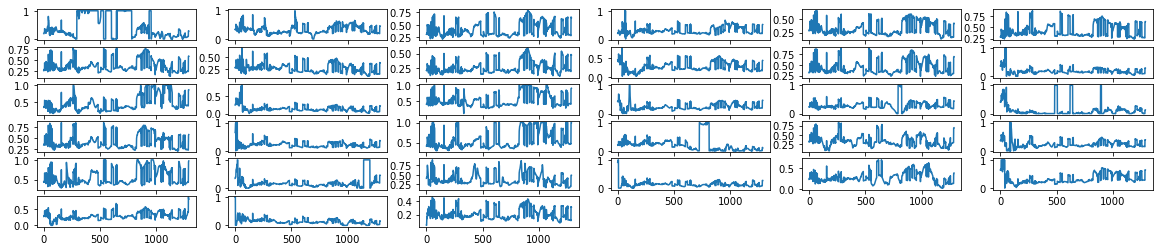

<Figure size 432x288 with 0 Axes>

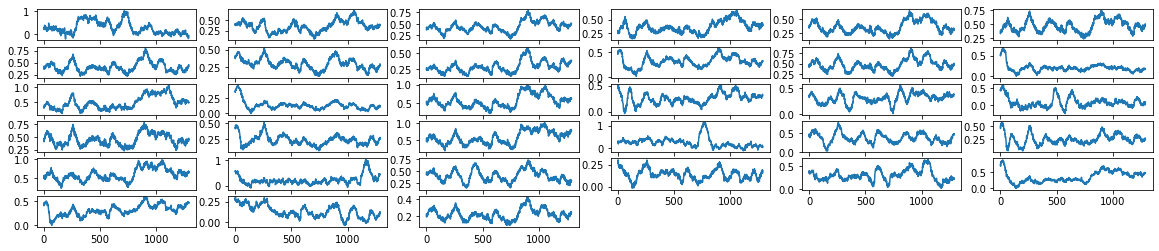

In [20]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

<Figure size 432x288 with 0 Axes>

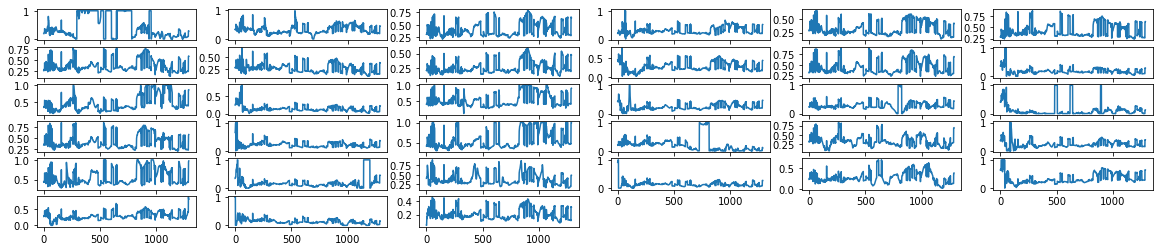

<Figure size 432x288 with 0 Axes>

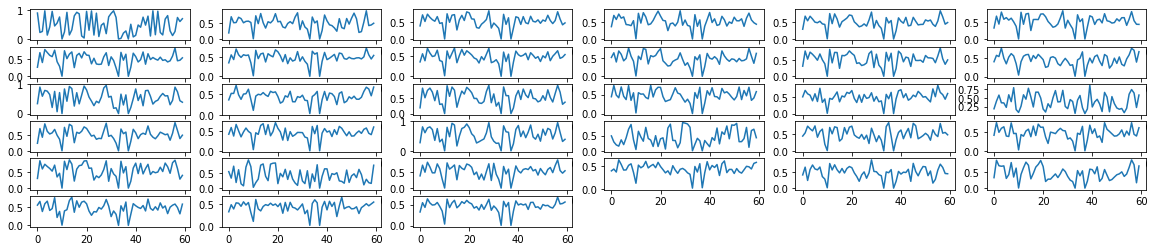

In [21]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

In [22]:
np.sum(np.mean(data2, axis=0) < 0.1)

3

Store the encoded representations in the data dictionary:

In [23]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [24]:
def get_ident_data_from_dict(idents, data_dict, should_scale_data=True):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    if should_scale_data:
        # Scale each data before returning
        phase = scale_data(phase)
        contractive_encoded = scale_data(contractive_encoded)
    
    return y, phase, contractive_encoded

In [25]:
# '62i9y''2gu87''iz2ps'

y_train, phase_train, contractive_encoded = get_ident_data_from_dict(['62i9y','2gu87'], data_dict)

phase_train2, y_train2, _, _, _ = get_data_from_idents_br_hb(path, ['62i9y','2gu87'], seconds)

phase_train2 = scale_data(phase_train2)

(phase_train == phase_train2).all()

True

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [26]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict, should_scale_data)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict, should_scale_data)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict, should_scale_data)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):

                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    set_random_seeds()
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [27]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [28]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [29]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.009973
iteration: 2 of 23 ; time elapsed: 0:00:05.370601
iteration: 3 of 23 ; time elapsed: 0:00:10.070450
iteration: 4 of 23 ; time elapsed: 0:00:14.713837
iteration: 5 of 23 ; time elapsed: 0:00:19.519473
iteration: 6 of 23 ; time elapsed: 0:00:24.606950
iteration: 7 of 23 ; time elapsed: 0:00:29.852167
iteration: 8 of 23 ; time elapsed: 0:00:35.126647
iteration: 9 of 23 ; time elapsed: 0:00:40.652960
iteration: 10 of 23 ; time elapsed: 0:00:46.351442
iteration: 11 of 23 ; time elapsed: 0:00:52.293407
iteration: 12 of 23 ; time elapsed: 0:00:58.260332
iteration: 13 of 23 ; time elapsed: 0:01:04.370340
iteration: 14 of 23 ; time elapsed: 0:01:11.083899
iteration: 15 of 23 ; time elapsed: 0:01:17.613801
iteration: 16 of 23 ; time elapsed: 0:01:24.151943
iteration: 17 of 23 ; time elapsed: 0:01:31.136849
iteration: 18 of 23 ; time elapsed: 0:01:38.224274
iteration: 19 of 23 ; time elapsed: 0:01:46.366660
iteration: 20 of 23 ; time elapsed: 0:01

In [30]:
accuracies['simple_dense'] = accs

In [31]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.541667,62i9y
1,0.764706,0.558824,2gu87
2,0.611111,0.527778,iz2ps
3,0.588235,0.500000,1mpau
4,0.633333,0.700000,7dwjy
5,0.625000,0.812500,7swyk
6,0.468750,0.500000,94mnx
7,0.566667,0.466667,bd47a
8,0.466667,0.700000,c24ur
9,0.600000,0.566667,ctsax


In [32]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.375000     0.406250
max     0.764706     0.812500
mean    0.543034     0.555302
median  0.529412     0.541667


#### LSTM-based classifier  
based on the original author's code

In [33]:
params_phase = {
    'kernel_size': 4,
    'filters': 3,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [35]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 2,
    'strides': 1,
    'pool_size': 1,
    'dropout': 0.09,
    'lstm_output_size': 4,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [36]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [37]:
accs = helper_loop(LSTM_train, idents, n=5)

iteration: 1 of 5 ; time elapsed: 0:00:00.006981
iteration: 2 of 5 ; time elapsed: 0:05:07.626070
iteration: 3 of 5 ; time elapsed: 0:10:15.981892
iteration: 4 of 5 ; time elapsed: 0:15:33.574931
iteration: 5 of 5 ; time elapsed: 0:21:06.783917
Completed! Time elapsed: 0:26:48.853227


In [38]:
accuracies['LSTM'] = accs

In [39]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.583333,0.583333,62i9y
1,0.529412,0.500000,2gu87
2,0.444444,0.555556,iz2ps
3,0.500000,0.411765,1mpau
4,0.400000,0.500000,7dwjy


In [40]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.400000     0.411765
max     0.583333     0.583333
mean    0.491438     0.510131
median  0.500000     0.500000


#### kNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [42]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [43]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.010971
iteration: 2 of 23 ; time elapsed: 0:00:00.096740
iteration: 3 of 23 ; time elapsed: 0:00:00.181513
iteration: 4 of 23 ; time elapsed: 0:00:00.263294
iteration: 5 of 23 ; time elapsed: 0:00:00.347101
iteration: 6 of 23 ; time elapsed: 0:00:00.429849
iteration: 7 of 23 ; time elapsed: 0:00:00.510658
iteration: 8 of 23 ; time elapsed: 0:00:00.586459
iteration: 9 of 23 ; time elapsed: 0:00:00.663226
iteration: 10 of 23 ; time elapsed: 0:00:00.738024
iteration: 11 of 23 ; time elapsed: 0:00:00.809897
iteration: 12 of 23 ; time elapsed: 0:00:00.896662
iteration: 13 of 23 ; time elapsed: 0:00:00.976422
iteration: 14 of 23 ; time elapsed: 0:00:01.055458
iteration: 15 of 23 ; time elapsed: 0:00:01.129260
iteration: 16 of 23 ; time elapsed: 0:00:01.201487
iteration: 17 of 23 ; time elapsed: 0:00:01.275292
iteration: 18 of 23 ; time elapsed: 0:00:01.350092
iteration: 19 of 23 ; time elapsed: 0:00:01.426884
iteration: 20 of 23 ; time elapsed: 0:00

In [44]:
accuracies['kNN'] = accs

In [45]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.541667,62i9y
1,0.588235,0.529412,2gu87
2,0.638889,0.666667,iz2ps
3,0.676471,0.617647,1mpau
4,0.700000,0.700000,7dwjy
5,0.812500,0.656250,7swyk
6,0.687500,0.625000,94mnx
7,0.600000,0.633333,bd47a
8,0.700000,0.533333,c24ur
9,0.666667,0.700000,ctsax


In [46]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.437500     0.500000
max     0.812500     0.794118
mean    0.637376     0.636573
median  0.638889     0.638889


####  SVC

In [47]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [48]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [49]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:00:00.824982
iteration: 3 of 23 ; time elapsed: 0:00:01.605405
iteration: 4 of 23 ; time elapsed: 0:00:02.374608
iteration: 5 of 23 ; time elapsed: 0:00:03.130584
iteration: 6 of 23 ; time elapsed: 0:00:03.872480
iteration: 7 of 23 ; time elapsed: 0:00:04.637256
iteration: 8 of 23 ; time elapsed: 0:00:05.368337
iteration: 9 of 23 ; time elapsed: 0:00:06.108879
iteration: 10 of 23 ; time elapsed: 0:00:06.851895
iteration: 11 of 23 ; time elapsed: 0:00:07.580775
iteration: 12 of 23 ; time elapsed: 0:00:08.308331
iteration: 13 of 23 ; time elapsed: 0:00:09.050345
iteration: 14 of 23 ; time elapsed: 0:00:09.761928
iteration: 15 of 23 ; time elapsed: 0:00:10.529939
iteration: 16 of 23 ; time elapsed: 0:00:11.336994
iteration: 17 of 23 ; time elapsed: 0:00:12.178004
iteration: 18 of 23 ; time elapsed: 0:00:13.007379
iteration: 19 of 23 ; time elapsed: 0:00:13.765351
iteration: 20 of 23 ; time elapsed: 0:00

In [50]:
accuracies['SVC'] = accs

In [51]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.583333,62i9y
1,0.676471,0.705882,2gu87
2,0.777778,0.777778,iz2ps
3,0.529412,0.588235,1mpau
4,0.666667,0.666667,7dwjy
5,0.468750,0.843750,7swyk
6,0.656250,0.687500,94mnx
7,0.633333,0.666667,bd47a
8,0.733333,0.733333,c24ur
9,0.633333,0.700000,ctsax


In [52]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.416667     0.375000
max     0.777778     0.843750
mean    0.600197     0.659873
median  0.633333     0.687500


#### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [54]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [55]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006978
iteration: 2 of 23 ; time elapsed: 0:00:03.093144
iteration: 3 of 23 ; time elapsed: 0:00:06.087093
iteration: 4 of 23 ; time elapsed: 0:00:09.085398
iteration: 5 of 23 ; time elapsed: 0:00:12.036251
iteration: 6 of 23 ; time elapsed: 0:00:15.118083
iteration: 7 of 23 ; time elapsed: 0:00:18.171857
iteration: 8 of 23 ; time elapsed: 0:00:21.226525
iteration: 9 of 23 ; time elapsed: 0:00:24.396347
iteration: 10 of 23 ; time elapsed: 0:00:27.851522
iteration: 11 of 23 ; time elapsed: 0:00:30.894209
iteration: 12 of 23 ; time elapsed: 0:00:33.889144
iteration: 13 of 23 ; time elapsed: 0:00:36.902046
iteration: 14 of 23 ; time elapsed: 0:00:39.796261
iteration: 15 of 23 ; time elapsed: 0:00:42.774654
iteration: 16 of 23 ; time elapsed: 0:00:45.709519
iteration: 17 of 23 ; time elapsed: 0:00:48.631912
iteration: 18 of 23 ; time elapsed: 0:00:51.589733
iteration: 19 of 23 ; time elapsed: 0:00:54.686674
iteration: 20 of 23 ; time elapsed: 0:00

In [56]:
accuracies['random_forest'] = accs

In [57]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.708333,0.750000,62i9y
1,0.588235,0.705882,2gu87
2,0.722222,0.833333,iz2ps
3,0.705882,0.676471,1mpau
4,0.600000,0.633333,7dwjy
5,0.750000,0.875000,7swyk
6,0.562500,0.531250,94mnx
7,0.600000,0.566667,bd47a
8,0.733333,0.433333,c24ur
9,0.700000,0.700000,ctsax


In [58]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.500000     0.333333
max     0.875000     0.875000
mean    0.669297     0.638178
median  0.676471     0.656250


#### Naive Bayesian

In [59]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [60]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [61]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.010969
iteration: 2 of 23 ; time elapsed: 0:00:00.090756
iteration: 3 of 23 ; time elapsed: 0:00:00.165555
iteration: 4 of 23 ; time elapsed: 0:00:00.244346
iteration: 5 of 23 ; time elapsed: 0:00:00.327127
iteration: 6 of 23 ; time elapsed: 0:00:00.402924
iteration: 7 of 23 ; time elapsed: 0:00:00.480716
iteration: 8 of 23 ; time elapsed: 0:00:00.551527
iteration: 9 of 23 ; time elapsed: 0:00:00.618348
iteration: 10 of 23 ; time elapsed: 0:00:00.684205
iteration: 11 of 23 ; time elapsed: 0:00:00.749505
iteration: 12 of 23 ; time elapsed: 0:00:00.813655
iteration: 13 of 23 ; time elapsed: 0:00:00.878624
iteration: 14 of 23 ; time elapsed: 0:00:00.950401
iteration: 15 of 23 ; time elapsed: 0:00:01.021613
iteration: 16 of 23 ; time elapsed: 0:00:01.086445
iteration: 17 of 23 ; time elapsed: 0:00:01.152506
iteration: 18 of 23 ; time elapsed: 0:00:01.215607
iteration: 19 of 23 ; time elapsed: 0:00:01.288410
iteration: 20 of 23 ; time elapsed: 0:00

In [62]:
accuracies['naive_bayesian'] = accs

In [63]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.625000,0.500000,62i9y
1,0.382353,0.441176,2gu87
2,0.305556,0.416667,iz2ps
3,0.500000,0.529412,1mpau
4,0.433333,0.566667,7dwjy
5,0.687500,0.718750,7swyk
6,0.500000,0.500000,94mnx
7,0.400000,0.466667,bd47a
8,0.466667,0.600000,c24ur
9,0.666667,0.566667,ctsax


In [64]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.294118     0.312500
max     0.735294     0.718750
mean    0.509914     0.502716
median  0.500000     0.500000


#### XGBoost

In [65]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [66]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [67]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.005983
iteration: 2 of 23 ; time elapsed: 0:00:02.766006
iteration: 3 of 23 ; time elapsed: 0:00:04.894741
iteration: 4 of 23 ; time elapsed: 0:00:06.950253
iteration: 5 of 23 ; time elapsed: 0:00:09.294196
iteration: 6 of 23 ; time elapsed: 0:00:11.422452
iteration: 7 of 23 ; time elapsed: 0:00:13.638409
iteration: 8 of 23 ; time elapsed: 0:00:15.813177
iteration: 9 of 23 ; time elapsed: 0:00:17.950046
iteration: 10 of 23 ; time elapsed: 0:00:20.100983
iteration: 11 of 23 ; time elapsed: 0:00:22.291105
iteration: 12 of 23 ; time elapsed: 0:00:24.432481
iteration: 13 of 23 ; time elapsed: 0:00:26.558806
iteration: 14 of 23 ; time elapsed: 0:00:28.777542
iteration: 15 of 23 ; time elapsed: 0:00:30.946761
iteration: 16 of 23 ; time elapsed: 0:00:32.931566
iteration: 17 of 23 ; time elapsed: 0:00:34.827059
iteration: 18 of 23 ; time elapsed: 0:00:36.790394
iteration: 19 of 23 ; time elapsed: 0:00:38.791222
iteration: 20 of 23 ; time elapsed: 0:00

In [68]:
accuracies['XGBoost'] = accs

In [69]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.625000,0.583333,62i9y
1,0.617647,0.647059,2gu87
2,0.666667,0.638889,iz2ps
3,0.735294,0.617647,1mpau
4,0.600000,0.600000,7dwjy
5,0.718750,0.781250,7swyk
6,0.625000,0.593750,94mnx
7,0.633333,0.533333,bd47a
8,0.566667,0.566667,c24ur
9,0.700000,0.633333,ctsax


In [70]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.466667     0.406250
max     0.735294     0.781250
mean    0.625753     0.630788
median  0.625000     0.617647


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [71]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.375000     0.406250
max     0.764706     0.812500
mean    0.543034     0.555302
median  0.529412     0.541667


----------- LSTM: -----------
           phase  contractive
min     0.400000     0.411765
max     0.583333     0.583333
mean    0.491438     0.510131
median  0.500000     0.500000


----------- kNN: -----------
           phase  contractive
min     0.437500     0.500000
max     0.812500     0.794118
mean    0.637376     0.636573
median  0.638889     0.638889


----------- SVC: -----------
           phase  contractive
min     0.416667     0.375000
max     0.777778     0.843750
mean    0.600197     0.659873
median  0.633333     0.687500


----------- random_forest: -----------
           phase  contractive
min     0.500000     0.333333
max     0.875000     0.875000
mean    0.669297     0.638178
median  0.676471     0.656250


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [72]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.416667     0.541667   62i9y
1   0.764706     0.558824   2gu87
2   0.611111     0.527778   iz2ps
3   0.588235     0.500000   1mpau
4   0.633333     0.700000   7dwjy
5   0.625000     0.812500   7swyk
6   0.468750     0.500000   94mnx
7   0.566667     0.466667   bd47a
8   0.466667     0.700000   c24ur
9   0.600000     0.566667   ctsax
10  0.617647     0.617647   dkhty
11  0.625000     0.593750   e4gay
12  0.468750     0.437500   ef5rq
13  0.400000     0.466667   f1gjp
14  0.437500     0.593750   hpbxa
15  0.527778     0.611111   pmyfl
16  0.638889     0.527778   r89k1
17  0.500000     0.406250   tn4vl
18  0.375000     0.500000   td5pr
19  0.441176     0.558824   gyqu9
20  0.500000     0.647059   fzchw
21  0.529412     0.500000   l53hg
22  0.687500     0.437500   3n2f9


LSTM:
      phase  contractive test id
0  0.583333     0.583333   62i9y
1  0.529412     0.500000   2gu87
2  0.444444     0.555556   iz2ps
3  0.500000     0.411765   1mp